In [4]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')
bus_stop_data = pd.read_csv('Data/bus_stop.csv')
# cluster_group_data = pd.read_csv('Data/cluster_group.csv')

general = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

data_set = coor_data.join((bus_stop_data.join(date_data.join(meta_data))))

from scipy import stats
# set_test = general[['trip_duration_min','trip_length_km']]
# data_set = data_set[(np.abs(stats.zscore(set_test)) < 3).all(axis=1)]
# general = general[(np.abs(stats.zscore(set_test)) < 3).all(axis=1)]




general_np = general.to_numpy()

# # filter
# data_set = data_set[np.logical_not(general_np[:, 6] > 10)]
# general_np = general_np[np.logical_not(general_np[:,6] > 10)]
# data_set = data_set[np.logical_not(general_np[:,6] < 0.01)]
# general_np = general_np[np.logical_not(general_np[:,6] < 0.01)]
# data_set = data_set[np.logical_not(general_np[:,5] > 120)]
# general_np = general_np[np.logical_not(general_np[:,5] > 120)]
# data_set = data_set[np.logical_not(general_np[:,5] < 1)]
# general_np = general_np[np.logical_not(general_np[:,5] < 1)]

data_set = data_set[np.logical_not(np.logical_and(general_np[:, 6] < 0.11, general_np[:, 5] > 20))]
general_np = general_np[np.logical_not(np.logical_and(general_np[:, 6] < 0.11, general_np[:, 5] > 20))]

Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy','start_date', 'end_near_stop']).to_numpy()

I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
I:\Users\PC\anaconda3\envs\my_env\lib\site-packages\tensorflow\python\framework

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np

census_by_community = gpd.read_file('Data/census_by_community1.shp')
grid_data = gpd.read_file('Data/ScooterGridId.shp')
data = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

centeroid_scale_grid = np.array([[x.centroid.x, x.centroid.y] for x in grid_data.geometry])
centeroid_scale_grid[:,0] = centeroid_scale_grid[:,0] + 180
lng_ltd = int(round(max(centeroid_scale_grid[:,0]) - min(centeroid_scale_grid[:,0]), 4) * 100)
lat_ltd = int(round(max(centeroid_scale_grid[:,1]) - min(centeroid_scale_grid[:,1]), 4) * 100)

map_mat = np.zeros((lat_ltd,lng_ltd))

max_lng = max(centeroid_scale_grid[:,0])
max_lat = max(centeroid_scale_grid[:,1])

shape = map_mat.shape

for pos in centeroid_scale_grid:
    pos_lng = abs(int(  ((max_lng - pos[0]))*100  )) - 1
    pos_lat = abs(int(  ((max_lat - pos[1]))*100  )) - 1
    map_mat[pos_lat, pos_lng] = 50



In [11]:
max_lat

51.186199069785

In [15]:
import progressbar 

# max_lng = max(data_set['endx'])
# max_lat = max(data_set['endy'])

map_end = []
for index, row in progressbar.progressbar(data_set.iterrows()):
    pos_lng = abs(int(  ((max_lng - (row['endx'] + 180) ))*100  )) - 1
    pos_lat = abs(int(  ((max_lat - (row['endy']) ))*100  )) - 1
    map_end.append(map_mat.copy())
    map_end[index][pos_lat, pos_lng] = 255
    map_end[index] = np.fliplr(map_end[index])
    
map_end = np.asarray(map_end)    

/ |                                #              | 23731 Elapsed Time: 0:00:03

IndexError: list index out of range

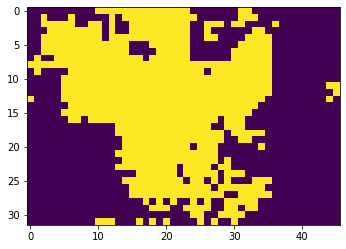

In [17]:
import matplotlib.pyplot as plt

plt.imshow(np.fliplr(map_mat))

In [25]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_data_n = scx.fit_transform(X_data)
Y_data_n = scy.fit_transform(Y_data)

scmap_end = MinMaxScaler(feature_range=(0,1))
map_end_ascolumns = map_end.reshape(len(map_end), -1)
map_end_n = scmap_end.fit_transform(map_end_ascolumns)
# map_end_n = tmap_end.reshape(map_end.shape)

x_train, x_test, y_train, y_test = train_test_split(X_data_n, Y_data_n, test_size=0.4, shuffle=False)
map_end_train = map_end_n[0:len(x_train)]
map_end_test = map_end_n[len(x_train):]

In [26]:
map_end_train.shape

(275686, 1472)

In [27]:
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
inputA = layers.Input(shape=(4))
inputB = layers.Input(shape=(60))

x = Dense(15)(inputA)
x = Dense(30, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
y = Dense(62)(inputB)
y = Dense(70, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

combined = layers.concatenate([x.output, y.output])

final = Dense(55, activation="relu")(combined)
image = Dense(map_end_n.shape[1])(final)

xx = Dense(15)(inputA)
xx = Dense(64, activation="relu")(xx)
xx = Model(inputs=inputA, outputs=xx)

yy = Dense(62)(inputB)
yy = Dense(64, activation="relu")(yy)
yy = Model(inputs=inputB, outputs=yy)


combined_twoa = layers.concatenate([xx.output, yy.output])


# xi = Dense(29)(image)
# xi = Dense(30, activation="relu")(xi)
combined_twob = layers.concatenate([combined_twoa, image])

final_two = Dense(55, activation="softmax")(combined_twob)

a = Dense(2)(final_two)

model = Model(inputs=[x.input,y.input], outputs=[a, image])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 15)           75          input_3[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 62)           3720        input_4[0][0]                    
____________________________________________________________________________________________

In [1]:
# from tensorflow.python.keras.callbacks import EarlyStopping

model.compile(loss="mean_absolute_error", optimizer="adam")

# callback = EarlyStopping(monitor='loss', patience=5, mode="auto")
# history = model.fit([x_train[:,0:7],x_train[:,7:]], [y_train[:,0:2], y_train[:,2:4]], epochs=100, validation_data=([x_test[:,0:7],x_test[:,7:]], [y_test[:,0:2], y_test[:,2:4]]))

history = model.fit([x_train[:,0:4],x_train[:,4:]], [y_train, map_end_train], epochs=50)

NameError: name 'model' is not defined

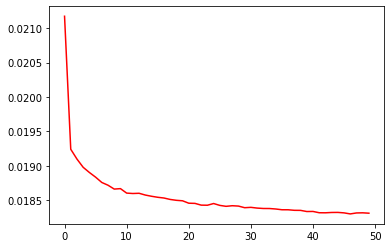

In [348]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='r')
plt.show()

In [349]:
model.evaluate([x_test[:,0:4],x_test[:,4:]], [y_test, map_end_test])

ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[0.59613727, 0.57843995],
       [0.61602473, 0.53988563],
       [0.57628952, 0.58099903],
       ...,
       [0.60277391, 0.56044666],
       [0.66890574, 0.57075995],
       [0.66890574, 0....

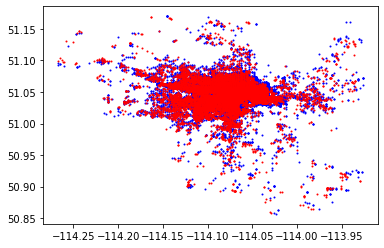

In [14]:
import matplotlib.pyplot as plt
import numpy as np
result = model.predict([x_test[:,0:4],x_test[:,4:]])

result_Y = result[0]
result_Y_plot = scy.inverse_transform(result_Y)
y_test_plot = scy.inverse_transform(y_test)

plt.scatter((y_test_plot[:,0]),(y_test_plot[:,1]), color='b', s= 1)
plt.scatter((result_Y_plot[:,0]), (result_Y_plot[:,1]), color='r', s= 1)



In [15]:
scmap_end.inverse_transform(result[1])
# result[1].reshape(map_end.shape)

array([[ 1.5007798e-05,  1.1770404e-05, -7.3874966e-05, ...,
         1.3614623e-04,  1.7402685e-04,  1.4120898e-04],
       [ 1.5007798e-05,  1.1770404e-05, -7.3874966e-05, ...,
         1.3614623e-04,  1.7402685e-04,  1.4120898e-04],
       [ 1.5007798e-05,  1.1770404e-05, -7.3874966e-05, ...,
         1.3614623e-04,  1.7402685e-04,  1.4120898e-04],
       ...,
       [ 1.5007798e-05,  1.1770404e-05, -7.3874966e-05, ...,
         1.3614623e-04,  1.7402685e-04,  1.4120898e-04],
       [ 1.5007798e-05,  1.1770404e-05, -7.3874966e-05, ...,
         1.3614623e-04,  1.7402685e-04,  1.4120898e-04],
       [ 1.5007798e-05,  1.1770404e-05, -7.3874966e-05, ...,
         1.3614623e-04,  1.7402685e-04,  1.4120898e-04]], dtype=float32)

In [16]:
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 5)
    km = round(km, 5)
    return km

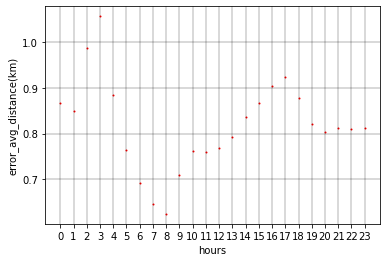

In [17]:
mae_rate_hour = []

x_test_hour = scx.inverse_transform(x_test)

result_Y_hour = scy.inverse_transform(result_Y)
y_test_hour = scy.inverse_transform(y_test)
for index in range(24):
    mask = np.logical_and(x_test_hour[:,3] > (index)-0.2, x_test_hour[:,3] < (index+1)-0.2)
    result_Y_d = result_Y_hour[mask]
    Y_test_in = y_test_hour[mask]
    error = 0
    for i in range(len(Y_test_in)):
        error = error + haversine(result_Y_d[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_hour.append([float(error_average_distance), str(index)])

mae_rate_hour = np.array(mae_rate_hour, dtype=np.object)
plt.xlabel('hours')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_hour[:,1], mae_rate_hour[:,0], color='r', s= 1)


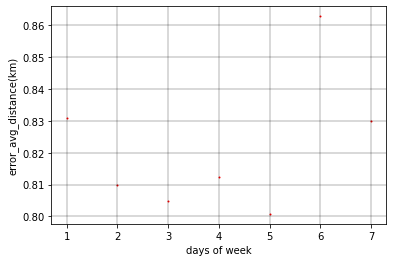

In [18]:
mae_rate_day_of_week = []

x_test_day = scx.inverse_transform(x_test)
x
result_Y_day = scy.inverse_transform(result_Y)
y_test_day = scy.inverse_transform(y_test)
for index in range(7):
    mask = np.logical_and(x_test_day[:,4] > (index)-0.1, x_test_day[:,4] < (index+1)-0.1)
    result_Y_d_day = result_Y_day[mask]
    Y_test_in = y_test_day[mask]
    error = 0
    haverList = []
    for i in (range(len(Y_test_in))):
        error = error + haversine(result_Y_d_day[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_day_of_week.append([error_average_distance, str(index+1)])

mae_rate_day_of_week = np.array(mae_rate_day_of_week, dtype=np.object)
plt.xlabel('days of week')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_day_of_week[:,1], mae_rate_day_of_week[:,0], color='r', s= 1)

In [20]:
result_Y_all = scy.inverse_transform(result_Y)
y_test_all = scy.inverse_transform(y_test)
error_all = 0
for i in (range(len(y_test_all))):
    error_all = error_all + haversine(result_Y_all[i],y_test_all[i])
    error_avg = error_all/len(y_test_all)
error_avg

0.8216708574366498